## EA run comparison

In [391]:
import os
import pandas as pd
import glob
import re

run_directory_prefix = "../models/NarxModelSearch/runs/"
file_name_pattern = "*Runs.csv"
columns = ["datetime", "iteration", "island", "cvMseMean", "cvMseStd", "cvSmapeMean", "cvSmapeStd", "holdoutRmse", "holdoutSmape", "holdoutMape", "holdoutMse", "holdoutIoa", "full_parameters"]

experiment_directories = ["18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_16_stations_calendar", 
                          "18CellularAutomata3DGrid3x3x3_20AgentsO3_1994-2018_16_stations_calendar", 
                          "18Islands20AgentsO3_1994-2018_16_stations_calendar", 
                          "18Islands5AgentsO3_1994-2018_16_stations_calendar",
                          "18CellularAutomata3DGrid3x3x3_5AgentsPM10_1994-2018_16_stations_calendar",
                          "18Islands20AgentsPM10_1994-2018_16_stations_calendar",
                          "18Islands5AgentsPM10_1994-2018_16_stations_calendar"
                         ]

run_directories = []
for experiment_directory in experiment_directories:
    new_run_directory = run_directory_prefix + experiment_directory + "/"
#     print("new_run_directory:", new_run_directory)
    run_directories.append(new_run_directory)

worker_directories = ["local", "TX2"]

# print(run_directories)

dirs_list = []
for run_directory in run_directories:
    dirs_list.append(os.listdir(run_directory))
#     print("dirs:", os.listdir(run_directory))
    
for dirs in dirs_list:
    for item in dirs:
        if item not in worker_directories:
            sub_items = os.listdir(run_directories[0] + item)
            for sub_item in sub_items:
                sub_path = item +"/" + sub_item
#                 print("sub_path:", item +"/" + sub_item)
                worker_directories.append(sub_path)
            
# print("worker_directories:", worker_directories)

paths = []
for run_directory in run_directories:
    for worker_directory in worker_directories:
        experiment = ""
        if run_directory.startswith(run_directory_prefix):
            experiment = run_directory[len(run_directory_prefix):-1]
#         print("experiment:", experiment)
        paths.append((run_directory + worker_directory + "/logs/", worker_directory, experiment))

# print(len(paths))
    
frames = []
for path in paths:
    for csv_file_path in glob.glob(path[0] + file_name_pattern):
#         print("csv_file_path:", csv_file_path)
#         print("csv_file     :", csv_file)
        df = pd.read_csv(csv_file_path, names=columns, engine="python", index_col="datetime", parse_dates=True)
        df.sort_index(inplace=True)
        df["optimizer"] = str(re.search('(.{1,6})Runs.csv', os.path.basename(csv_file_path)).group(1))
        df["worker"] = path[1]
        df["experiment"] = path[2]
        df["cummin_holdoutSmape"] = df["holdoutSmape"].cummin()
        df["cummin_cvMseMean"] = df["cvMseMean"].cummin()
#         print("df.shape", df.shape)
        frames.append(df)

df = pd.concat(frames)
df.sort_index(inplace=True)

print("df.shape:", df.shape)
df.tail()        

df.shape: (6659, 17)


,datetime,island,cvMseMean,cvMseStd,cvSmapeMean,cvSmapeStd,holdoutRmse,holdoutSmape,holdoutMape,holdoutMse,holdoutIoa,full_parameters,optimizer,worker,experiment,cummin_holdoutSmape,cummin_cvMseMean
iteration,,,,,,,,,,,,,,,,,
170,1563265829,4,178.809136,53.376605,8.977854,1.647982,14.493288,8.857431,inf,210.055391,0.954863,"[8.0, 544.0, 4.0, 422.0, 268.0, 355.0, 0.11026...",rand,local,18Islands5AgentsO3_1994-2018_16_stations_calendar,7.653691,157.060959
171,1563265995,14,437.493824,66.741426,13.012070,1.044839,25.536783,12.905409,inf,652.127279,0.754256,"[25.0, 371.0, 1.0, 470.0, 245.0, 129.0, 0.1764...",rand,EC2/1xV100,18Islands20AgentsO3_1994-2018_16_stations_cale...,7.653691,157.060959
171,1563265995,14,437.493824,66.741426,13.012070,1.044839,25.536783,12.905409,inf,652.127279,0.754256,"[25.0, 371.0, 1.0, 470.0, 245.0, 129.0, 0.1764...",rand,EC2/1xV100,18Islands20AgentsO3_1994-2018_16_stations_cale...,7.653691,157.060959
171,1563265995,14,437.493824,66.741426,13.012070,1.044839,25.536783,12.905409,inf,652.127279,0.754256,"[25.0, 371.0, 1.0, 470.0, 245.0, 129.0, 0.1764...",rand,local,18Islands5AgentsO3_1994-2018_16_stations_calendar,7.653691,157.060959
171,1563265995,14,437.493824,66.741426,13.012070,1.044839,25.536783,12.905409,inf,652.127279,0.754256,"[25.0, 371.0, 1.0, 470.0, 245.0, 129.0, 0.1764...",rand,EC2/1xV100,18Islands20AgentsO3_1994-2018_16_stations_cale...,7.653691,157.060959


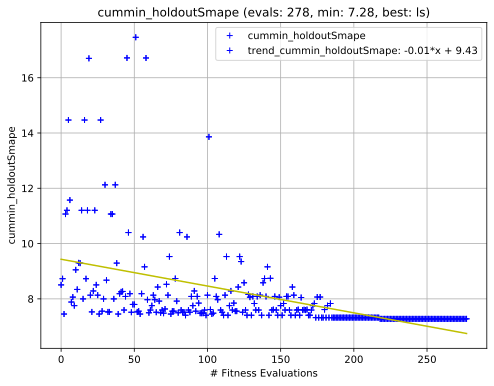

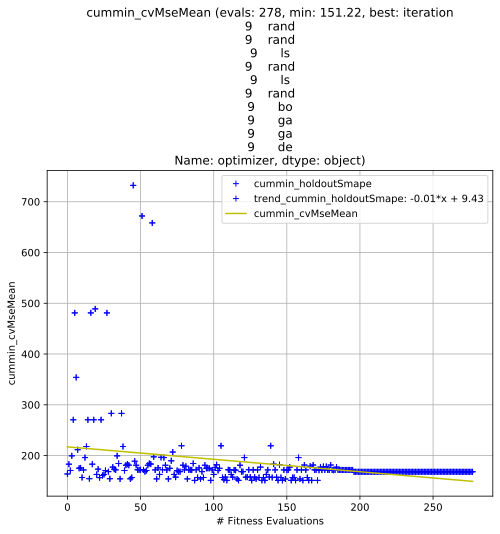

In [392]:
import numpy as np

variables = [
#     "cvMseMean", "holdoutSmape", 
    "cummin_holdoutSmape",
    "cummin_cvMseMean"
]
figure_size = [8, 6]      
remove_outliers = False
outlier_std = 1

    
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]


for current_experiment in experiment_directories:
    
    legends = []
    for variable in variables:    
       
        df2 = df.loc[df["experiment"] == current_experiment]        
        df2 = df2.drop_duplicates()
        
        y = np.array(df2[variable])        
        
        if remove_outliers:
            y = reject_outliers(y, outlier_std)
    
        best_method = df2["optimizer"].loc[df2[variable].idxmin()]       
        x = np.array(range(0, len(y)))
        
        fig, ax = plt.subplots(1, 1, figsize=figure_size)
        ax.set_ylabel(variable)
        ax.set_xlabel('# Fitness Evaluations')

        z = np.polyfit(x, y, 1) 
        ax.set_title('{} (evals: {}, min: {:.2f}, best: {})'.format(variable, len(df2[variable]), min(y), best_method))
        ax.grid(True)        
        ax.plot(x, y, "b+");         
        ax.plot(x, y, "b+");
        ax.plot(x, np.array(z[0] * x + z[1]), 'y')        
#         ax.boxplot(y, showfliers=False, vert=False, showmeans=True, meanline=True);           
        legends.append(variable)
        legends.append("trend_" + variable + ": {:.2f}*x + {:.2f}".format(z[0], z[1]))
        ax.legend(legends)
    
#         break
    break

In [331]:
df = pd.DataFrame(np.random.randn(1000, 5))

from scipy import stats
print(len(df))
df2 = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
print(len(df2))

1000
985


In [342]:
S = pd.Series(np.random.normal(size=20000))
print(len(S))
S2 = S[~((S-S.mean()).abs() > 3*S.std())]
print(len(S2))

20000
19955
